In [436]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score



### Process 1 - About the Data

##### a) load data

In [419]:
data_url = 'housing_prices/dataset/housing.csv'

In [420]:
def load_housing_data(housing_path=''):
    return pd.read_csv(housing_path)

housing = load_housing_data(housing_path=data_url)

##### b) get info about data

In [421]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [422]:
# checking for missing data
housing.info()
# missing data at bedrooms

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [423]:
housing.describe()

# check the main jupyter for more

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


##### c) creating train and test data

<Axes: >

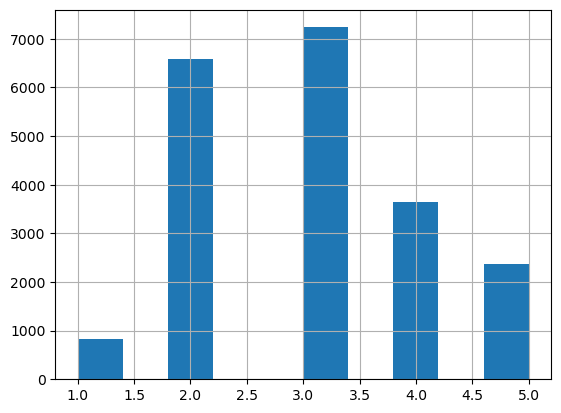

In [424]:
# lets create a train and test data split and not touch the test data for now

# using stratification method.. to make sure the data is not biased due to skewness
# since the data will base on using the "median income" for the projections
# lets split the categories of income base on 5 classes.. and see if we have the
# distribution for all categories.
# we will then split the data based on this (Stratification)

housing['income_cat'] = pd.cut(housing['median_income'], bins=[
                               0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])

housing['income_cat'].hist()

In [425]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


## now to remove income_cat after stratification.
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


##### d) data preperation - removing empty cells, scaling, encoding, etc, using Pipes

In [426]:
# separating labels and predictors
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

housing.info()
housing_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB
<class 'pandas.core.series.Series'>
Index: 16512 entries, 12655 to 19773
Series name: median_house_value
Non-Null Count  Dtype  
--------------  -----  
16512 non-null  float64
dtypes: float64(1)
memory usage: 258.0 KB


In [427]:
# # considering using numeric and texts
housing_cat = housing[['ocean_proximity']]
housing_num = housing.drop("ocean_proximity", axis=1)

print(housing_cat.head())
housing_num.head()

      ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [428]:
# a transformer to add more attributes base on others

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [429]:
# imputer to clean to fill in gaps in data base on median... target is the total rooms
imputer = SimpleImputer(strategy="median")

In [430]:
# using pipelines

# for numerics
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])


In [431]:
# for the full pipeline dealing with the text and numeric
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]


full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
], sparse_threshold=0.3)

housing_prepared = full_pipeline.fit_transform(housing)
pd_check = pd.DataFrame(housing_prepared)

pd_check.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.017395,0.006223,-0.121122,0.0,1.0,0.0,0.0,0.0
1,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.569256,-0.040811,-0.810867,0.0,0.0,0.0,0.0,1.0
2,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,-0.018024,-0.075371,-0.338273,0.0,1.0,0.0,0.0,0.0
3,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,-0.595140,-0.106803,0.961205,0.0,0.0,0.0,0.0,1.0
4,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,0.251241,0.006109,-0.474513,1.0,0.0,0.0,0.0,0.0


### Process 2 - Model selection and evaluation

In [432]:
# training model -- linear regression

lin_reg = LinearRegression()

# lin_reg.fit(housing_prepared, housing_labels)


In [433]:
def display_scores(scores):
    print("Scores",  scores)
    print("Mean", scores.mean())
    print("Standard deviation", scores.std())

In [434]:
lin_scores = cross_val_score(
    lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)

_scores = np.sqrt(-lin_scores)

display_scores(_scores)


Scores [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean 69104.07998247063
Standard deviation 2880.328209818065


### Exercise solutions

##### 1.

Question: Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [435]:
# Question 1
# using SVM

svm_reg = SVR()

svm_scores = cross_val_score(svm_reg,  housing_prepared,
                             housing_labels, scoring='neg_mean_squared_error', cv=5, verbose=2)

_scores = np.sqrt(-svm_scores)

display_scores(_scores)

[CV] END .................................................... total time=  18.0s
[CV] END .................................................... total time=  14.8s
[CV] END .................................................... total time=  16.2s
[CV] END .................................................... total time=  15.3s
[CV] END .................................................... total time=  15.0s
Scores [118564.07959881 117062.66548405 118839.04790705 119125.54141514
 119585.23991677]
Mean 118635.31486436282
Standard deviation 855.860662189781


In [437]:
param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=10.0, kernel=linear; total time=   6.6s
[CV] END ..............................C=10.0, kernel=linear; total time=   6.5s
[CV] END ..............................C=10.0, kernel=linear; total time=   6.9s
[CV] END ..............................C=10.0, kernel=linear; total time=   7.1s
[CV] END ..............................C=10.0, kernel=linear; total time=   6.6s
[CV] END ..............................C=30.0, kernel=linear; total time=   6.7s
[CV] END ..............................C=30.0, kernel=linear; total time=   6.6s
[CV] END ..............................C=30.0, kernel=linear; total time=   7.1s
[CV] END ..............................C=30.0, kernel=linear; total time=   6.8s
[CV] END ..............................C=30.0, kernel=linear; total time=   6.9s
[CV] END .............................C=100.0, kernel=linear; total time=   7.3s
[CV] END .............................C=100.0, 

70286.6183460516